# BUSINESS ANALYTICS
## STUDY CASE: Lending Club

In [6]:
# General utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import seaborn as sns
import datetime
import pickle
import time
import collections
import os
import warnings
from sys import platform

# Sklearn utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, linear_model
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error
from sklearn.metrics import r2_score, auc, precision_recall_curve, f1_score, confusion_matrix, mean_absolute_error
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

# Sklearn classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LassoLars
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Other packages
from scipy.stats import kendalltau
from six import StringIO
from IPython.display import Image
import pydotplus
import gurobipy as gp
from gurobipy import GRB

# Load debugger, if required
pd.options.mode.chained_assignment = None

# Suppress all warnings
warnings.filterwarnings("ignore")

## WK1/Phase1 - Ingestion and Cleaning

### Step 1 - Ingestion

In [7]:
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

In [15]:
# Example using Windows
dir_data = "C:\\Users\\ly266e\\Documents\\Training\\CMU\\Master\\Fall 2023 Mini 7\\Business_Analytics\\HW\\HW6\\Data"

In [16]:
from typing import Dict, final
def ingest_files(directory: str) -> Dict:
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    Lending Club, and *only* those files. Thus, we assume the files are zipped
    (pd.read_csv can read zipped files) and we assume the first line
    in each file needs to be skipped. 
    
    Note that this function will read and ingest more than one file and is
    convenient if you want to ingest data for more than one year at a time.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = (output[i].id.apply( lambda x : is_integer(x) == False ))
        if invalid_rows.sum() > 0:
            print("        Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][invalid_rows == False]
    
    return output

In [17]:
# Ingest the set of files we downloaded 
files_data = ingest_files(dir_data)

Directory C:\Users\ly266e\Documents\Training\CMU\Master\Fall 2023 Mini 7\Business_Analytics\HW\HW6\Data/ has 2 files:
    Reading file LoanStats3c.csv
        Found 4 invalid rows which were removed
    Reading file LoanStats3d.csv
        Found 5 invalid rows which were removed


In [18]:
files_data.keys()

dict_keys(['LoanStats3c.csv', 'LoanStats3d.csv'])

In [19]:
data_now = pd.concat(files_data.values()).reset_index(drop = True)
columns = list(data_now.columns)

In [20]:
print(f"The number of columns is: {len(columns)}")

The number of columns is: 144


In [21]:
print("Starting with " + str(len(data_now)) + " rows")

Starting with 656724 rows


### Step 2 - Choose Columns and Prepare Dataset

In [22]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id','loan_amnt','funded_amnt','term','int_rate'
                ,'grade','emp_length', 'home_ownership',
                'annual_inc','verification_status','issue_d',
                'loan_status','purpose','dti', 'delinq_2yrs','open_acc','pub_rec',
                'revol_bal','revol_util', 'total_pymnt', 'recoveries',
                'inq_last_6mths', 'pct_tl_nvr_dlq', 'last_pymnt_d', 'earliest_cr_line']

# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'annual_inc',
              'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
              'total_pymnt', 'recoveries', 'inq_last_6mths']

cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']

perc_cols = ['int_rate', 'revol_util', 'pct_tl_nvr_dlq']

date_cols = ['issue_d', 'last_pymnt_d', 'earliest_cr_line']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [23]:
# Keep only the columns of interest
final_data = data_now[cols_to_pick].copy()

#### Typecast the columns

In [24]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float)

In [25]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    
    # If x is already a float (or int), return it as is
    if isinstance(x, (float, int)):
        return float(x)
    
    x = x.rstrip()
    if x.endswith('%'):
        x = x[:-1]
        
    if x == '':
        return np.nan
    else:
        return float(x)
    
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )

In [26]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime(x, "%b-%y").date()

# Assuming final_data is your DataFrame and date_cols contains the date columns
for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date)

In [27]:
for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None

### Step 3 - Handle outliers

In [28]:
# There are quite a few outliers, but the two most obvious ones to remove are in annual_inc, revol_bal Remove these.
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 1000000]
final_data = final_data[final_data.revol_bal < 400000]
final_data = final_data[final_data.dti < 200]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 345 rows


In [29]:
# Remove all loans that are too recent to have been paid off or defaulted
n_rows = len(final_data)
final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


In [30]:
# Only include loans issued since 2009
n_rows = len(final_data)
final_data = final_data[final_data.issue_d >= datetime.date(2009, 1, 1)]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


#### Outlier detection and Data Cleaning

In [31]:
def flag_and_limit_outliers(df, cols, z_threshold=3):
    from scipy import stats
    
    """
    Flag outliers in specified columns using Z-score method and return the upper limit.
    
    Parameters:
        df (DataFrame): Input DataFrame
        cols (list): List of columns to check for outliers
        z_threshold (float): Z-score threshold for flagging outliers. Defaults to 3.
        
    Returns:
        DataFrame: DataFrame with additional columns to flag outliers
        dict: Dictionary with upper limits for each column
    """
    df_outliers = df.copy()
    upper_limits = {}
    
    for col in cols:
        col_mean = df_outliers[col].mean()
        col_std = df_outliers[col].std()
        
        # Calculate upper limit for each column
        upper_limit = col_mean + (z_threshold * col_std)
        upper_limits[col] = upper_limit
        
        # Flag outliers in DataFrame
        df_outliers[f"{col}_outlier"] = (df_outliers[col] > upper_limit).astype(int)
        
    return df_outliers, upper_limits

In [32]:
columns_to_check = ['annual_inc', 'inq_last_6mths', 'total_pymnt', 'open_acc']

# Flag outliers and get upper limits
df_outliers_flagged, upper_limits = flag_and_limit_outliers(final_data, columns_to_check)

In [33]:
outliers_columns = ['annual_inc', 'inq_last_6mths', 'total_pymnt', 'open_acc']
upper_limits_filtered = {k: upper_limits[k] for k in outliers_columns if k in upper_limits}

In [34]:
# Remove outliers based on upper limits
n_rows = len(final_data)
for col, upper_limit in upper_limits_filtered.items():
    final_data = final_data[final_data[col] <= upper_limit]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 31975 rows


#### Drop null values

In [35]:
# Deal with null values. We allow categorical variables to be null. OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop rows that do not meet this requirement
required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 676 rows


In [36]:
# Some of the columns selected will not be used directly in the model, but will be used to generate other features.

# All categorical columns other than "loan_status" will be used as discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## WK2/Phase2 - Diagnostic and Descriptive Analysis

### Step 4 - Calculate returns for each loan

In [37]:
### Define the names of the four returns we'll be calculating
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc"]

In [38]:
## Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1080 rows


#### Return Method 2 (pessimistic)

In [39]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (method 2)
final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int)
final_data['ret_PESS'] = ( (final_data.total_pymnt - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['term_num'])

#### Return Method 1 (optimistic)

In [40]:
# Assuming that if a loan gives a positive return, we can immediately find a similar loan to invest in; 
#if the loan takes a loss, we use method 2 to compute the return
final_data['ret_OPT'] = ( (final_data.total_pymnt - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['loan_length'])
final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.ret_PESS[final_data.ret_OPT < 0]

#### Return Method 3 (re-investment)

In [41]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''

    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )

    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries

    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )

final_data['ret_INTa'] = ret_method_3(5*12, 0.001)
final_data['ret_INTb'] = ret_method_3(5*12, 0.0025)
final_data['ret_INTc'] = ret_method_3(5*12, 0.005)

## WK3/Phase3  - Predicting Default Probability

In [42]:
# Define a function that, given a CVGridSearch object, finds the percentage difference between the best and worst scores

def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object, whether the optimal parameters lie on the edge of the search grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

### Define a default random seed and an output file

In [43]:
default_seed = 1
output_file = "output_test1"

In [44]:
# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

### Load the data and engineer the features

In [45]:
# Create the outcome
final_data["outcome"] = final_data.loan_status.isin(["Charged Off", "Default"])

# Create a feature for the length of a person's credit history at the
# time the loan is issued
final_data['cr_hist'] = (final_data.issue_d - final_data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
final_data['train'] = np.random.choice([True, False], size = len(final_data), p = [0.7, 0.3])

In [46]:
data_kmeans = final_data.copy()
data_kmeans['loan_status_binary'] = data_kmeans['outcome'].apply(lambda x: 1 if x == True else 0)
continuous_features_kmeans = continuous_features.copy()
continuous_features_kmeans.append('loan_status_binary')
data_kmeans = data_kmeans[['int_rate', 'annual_inc','loan_amnt', 'dti','inq_last_6mths', 'open_acc', 'total_pymnt']]

In [47]:
df_st =  StandardScaler().fit_transform(data_kmeans) # this is an array

# see few rows of standardized dataset
pd.DataFrame(df_st, columns=data_kmeans.columns).head()

,int_rate,annual_inc,loan_amnt,dti,inq_last_6mths,open_acc,total_pymnt
0,-0.126838,0.189313,0.026687,-0.803985,-0.711305,-1.115271,0.115949
1,-1.380691,-0.371253,-0.529553,-0.461659,1.774399,1.105701,-0.923345
2,0.168050,-0.595479,-0.862087,1.894352,0.531547,-0.105739,-1.340743
3,0.976089,1.506641,-0.239341,-1.244626,-0.711305,-0.711458,0.286870
4,0.616187,-0.208689,0.803608,-0.038785,-0.711305,-0.307645,0.898727


In [48]:
K=3
kmeans = KMeans(n_clusters=K, random_state=10).fit(df_st)
labels = kmeans.labels_
collections.Counter(labels) # show the number of occurences of each of the labels

Counter({0: 251224, 1: 204116, 2: 167308})

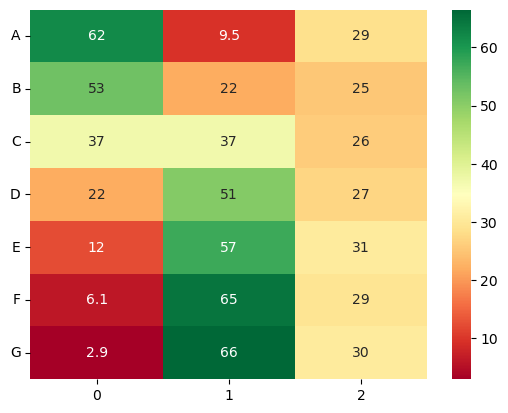

In [50]:
grade =  final_data.grade.to_numpy() # np_array
K=3
ltr2num = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
table = np.zeros([7,K]) # row = letter grade, column = kmeans label
for j in range(df_st.shape[0]):
    table[ltr2num[grade[j]], labels[j]]+=1 # confusion matrix
for i in range(7):
    table[i,:] = np.round(table[i,:]*100/table[i,:].sum(), 1)

df_temp = pd.DataFrame(table, columns = [0,1,2])
# visulaize confusion matrix using heatmap
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.heatmap(df_temp, annot=True, cmap='RdYlGn',  yticklabels=grades)
plt.yticks(rotation=0, ha='right')  # ha is the horizontal alignment
plt.show()

In [51]:
final_data['kmeans'] = labels

In [52]:
#Categorical
discrete_features.remove('grade')

In [53]:
#Continuous
features_to_remove = ['funded_amnt'] #It cannot be removed until now
continuous_features = [feature for feature in continuous_features if feature not in features_to_remove]

In [54]:
columns_to_remove = ['home_ownership_RENT', 'purpose_credit_card', 'purpose_house', 'home_ownership_OTHER', 'cr_hist', 'verification_status_Verified']

In [55]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = final_data[continuous_features].values
X_discrete = pd.get_dummies(final_data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
discrete_features_dummies = [feature for feature in discrete_features_dummies if feature not in columns_to_remove]
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
y = final_data.outcome.values

train = final_data.train.values

### Prepare functions to fit and evaluate models

In [69]:
def prepare_data_imb(data_subset = np.array([True]*len(final_data)),
                          n_samples_train = 20000,
                          n_samples_test = 10000,
                          feature_subset = None,
                          date_range_train = (final_data.issue_d.min(), final_data.issue_d.max()),
                          date_range_test = (final_data.issue_d.min(), final_data.issue_d.max()),
                          random_state = default_seed):
    
    '''
    This function prep the data for further analysis, but also takes care of the class imbalance situation
    '''
    
    np.random.seed(random_state)
    
    filter_train = ( train & (final_data.issue_d >= date_range_train[0]) &
                            (final_data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (final_data.issue_d >= date_range_test[0])
                            & (final_data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum() 
                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum() 
                                   - n_samples_test, replace = False ) ] = False
    
    # Get training data and labels
    X_temp_train = X[filter_train, :]
    y_temp_train = y[filter_train]
    
    # Separate majority and minority classes
    X_majority = X_temp_train[y_temp_train == False]
    X_minority = X_temp_train[y_temp_train == True]
    y_majority = y_temp_train[y_temp_train == False]
    y_minority = y_temp_train[y_temp_train == True]
    
    # Downsample majority class
    X_majority_downsampled = X_majority[:len(X_minority)]
    y_majority_downsampled = y_majority[:len(y_minority)]
    
    # Combine minority class with downsampled majority class
    X_train_balanced = np.vstack((X_majority_downsampled, X_minority))
    y_train_balanced = np.hstack((y_majority_downsampled, y_minority))
    
    # Prepare the test set
    X_test = X[filter_test, :]
    y_test = y[filter_test]
    
    # Feature selection if specified
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train_balanced = X_train_balanced[:, cols]
        X_test = X_test[:, cols]
        
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()
    X_train_balanced = scaler.fit_transform(X_train_balanced)
    X_test = scaler.transform(X_test)
    
    out = {'X_train': X_train_balanced, 'y_train': y_train_balanced, 'train_set': filter_train, 
           'X_test': X_test, 'y_test': y_test, 'test_set': filter_test}
    
    return out

In [70]:
def prepare_data_all(data_subset = np.array([True]*len(final_data)),
                    n_samples_train = 20000,
                    n_samples_test = 10000,
                    feature_subset = None,
                    date_range_train = (final_data.issue_d.min(), final_data.issue_d.max()),
                    date_range_test = (final_data.issue_d.min(), final_data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that rowFdecisipn
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
    
    # Filter down the data to the required date range, and downsample
    # as required
#     print("sizes:", train.shape[0], data.shape[0], data_subset.shape[0])
    filter_train = ( train & (final_data.issue_d >= date_range_train[0]) &
                            (final_data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (final_data.issue_d >= date_range_test[0])
                            & (final_data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum() 
                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum() 
                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [58]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
#     tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
#     if print_to_screen:
#         print("")
#         print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

In [59]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False,
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen

    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']

    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}

    for ret_col in col_list:

        #y_train = data.loc[filter_train, ret_col].as_matrix()
        #y_test = data.loc[filter_test, ret_col].as_matrix()
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_

            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)

            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_

            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### Feature preparation

In [71]:
# final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]
final_features = [i for i in discrete_features + continuous_features]
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]

## useful when choosing the most significant features
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [72]:
## Process data here: This one is for class imbalance conditions
data_dict = prepare_data_imb(data_subset = np.array([True]*len(final_data)), feature_subset = final_features)

# Checking the number of Trues and Falses in the y_train from the provided data dictionary
true_count = np.sum(data_dict['y_train'])
false_count = len(data_dict['y_train']) - true_count
true_count, false_count

(3698, 3698)

In [73]:
## Process data here: This does not take care of class imbalance
data_dict_reg = prepare_data_all(data_subset = np.array([True]*len(final_data)), feature_subset = final_features)

# Checking the number of Trues and Falses in the y_train from the provided data dictionary
true_count = np.sum(data_dict_reg['y_train'])
false_count = len(data_dict_reg['y_train']) - true_count
true_count, false_count

(3698, 16302)

### $l_1$ penalized logistic Classifier

  Model: l1 Penalized Logistic Regression
Fit time: 443.37 seconds
Optimal parameters:
{'C': 464.15888336127773}

Accuracy-maximizing threshold was: 0.3752804021744568
Accuracy:  0.9847
              precision    recall  f1-score   support

  No default     0.9905    0.9908    0.9907      8188
     Default     0.9585    0.9570    0.9577      1812

    accuracy                         0.9847     10000
   macro avg     0.9745    0.9739    0.9742     10000
weighted avg     0.9847    0.9847    0.9847     10000



NameError: name 'calibration_curve' is not defined

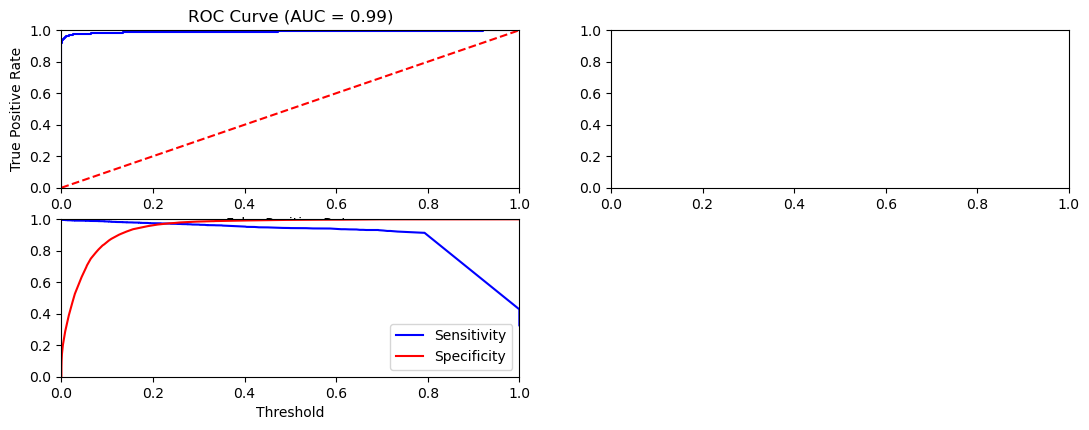

In [74]:
#Run the following the first time through
l1_logistic = LogisticRegression(penalty = 'l1',solver='saga', max_iter=10000, n_jobs=-1)
cv_parameters = {"C":np.logspace(0, 6, num = 10)}
l1_logistic_all = fit_classification(l1_logistic, data_dict,
                      cv_parameters = cv_parameters, model_name = "l1 Penalized Logistic Regression")

In [ ]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l1_logistic_all['model'].coef_)[0,:3]) + list(np.argsort(l1_logistic_all['model'].coef_)[0,-3:])
bplot = pd.Series(l1_logistic_all['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,5))
p1.set_xticklabels(xticks)
plt.title('Most significant features of l1_logistic_all')
plt.show()

### Random Forest Classifier

In [ ]:
#Run the following the first time through
rf = RandomForestClassifier(n_jobs=-1)
cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20, 40], 'n_estimators': [35, 60, 80, 100, 150] }
rf_all = fit_classification(rf, data_dict, cv_parameters = cv_parameters, model_name = "Random Forest")

### Build and Test Regression Models for returns

### Lasso-Lars regressor

In [ ]:
# Single Regressor
cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }
reg_lasso = fit_regression(linear_model.LassoLars(), data_dict_reg,  
               cv_parameters = cv_parameters, separate = False, model_name = "Lasso")

In [ ]:
# Two Models
cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }
reg_separate = fit_regression(linear_model.LassoLars(), data_dict_reg,  
               cv_parameters = cv_parameters, separate = True, model_name = "Lasso")

### Save the models in one file or save the whole session in a dill file
Some of the models take long time to train. You may put your models in a dictionary and save it by running: 

In [ ]:
# save all time-consuming models in one dict_ 
models_to_save = {}
models_to_save['reg_lasso'] = reg_lasso
models_to_save['reg_separate'] = reg_separate
models_to_save['l1_logistic_all'] = l1_logistic_all
models_to_save['rf_all'] = rf_all

# os.path.abspath(os.getcwd()) # get current directory
filename = './week4_saved_models'
outfile = open(filename,'wb')
pickle.dump(models_to_save, outfile)
outfile.close()

## WK4/Phase4 - Picking Loans using Regression of Loan Returns

### Test investment strategies
Now we test several investment strategies using the learning models above

In [ ]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random',
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns.
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.

    It is currently able to test four strategies
      - random: invest in a random set of loans
      - ranking: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - regression: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - two-stage: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
      - knapsack: 

    It expects the following parameters
      - data: the data set we are using now
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file

    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''

    np.random.seed(random_state)

    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']

    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}

    for ret_col in col_list:

        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Regression':

            colname = 'predicted_return_' + ret_col

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Ranking':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Two-stage':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col

            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return +
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Greedy':

            # Sort the loans by return-to-risk ratio:
            temp1 = regressor["ret_INTc"]['predicted_return']
            #temp1 = data_test.ret_INTc.to_numpy() # return
            temp2 = data_test['score'].to_numpy() # default probability
            data_test['ratio'] = temp1/temp2
            data_test = data_test.sort_values(by='ratio', ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        elif strategy == 'KMeans':
            
            # Extract unique kmeans values
            kmeans_values = data_test['kmeans'].unique()

            for kmean_val in kmeans_values:

                # Subset data based on current kmean value
                data_subset = data_test[data_test['kmeans'] == kmean_val].copy()

                # Reset the index of the subset for direct indexing
                data_subset.reset_index(drop=True, inplace=True)

                # Filter the predicted returns to match the data_subset length
                predicted_regular_return_subset = regressor[ret_col]['predicted_regular_return'][data_subset.index]
                predicted_default_return_subset = regressor[ret_col]['predicted_default_return'][data_subset.index]

                # Load the predicted returns
                data_subset['predicted_regular_return'] = predicted_regular_return_subset
                data_subset['predicted_default_return'] = predicted_default_return_subset

                # Compute expectation
                colname = 'predicted_return_' + ret_col

                data_subset[colname] = ((1-data_subset.score) * data_subset.predicted_regular_return +
                                        data_subset.score * data_subset.predicted_default_return)

                # Sort the loans by predicted return
                data_subset = data_subset.sort_values(by=colname, ascending = False).reset_index(drop = True)

                # Pick num_loans loans
                pf_test = data_subset[['funded_amnt',ret_col]].iloc[:num_loans]

                # Find their return
                ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

                # Return
                out_key = ret_col + "_kmean_" + str(kmean_val)  # Use a unique key for each kmean value
                out[out_key] = {'strategy':strategy, 'kmean':kmean_val, 'average return':ret_test, 'test data':data_subset}

                # Dump the strategy performance to file
                if output_to_file:
                    dump_to_output(strategy + "," + ret_col + "_kmean_" + str(kmean_val) + "::average return", ret_test)

            continue

        elif strategy == 'Crystal-ball':

            # Sort the loans by realized return
            data_test = data_test.sort_values(by=ret_col, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'

    return out

In [ ]:
train_set = data_dict_reg['train_set']
test_set = data_dict_reg['test_set']

# Create a dataframe for testing, including the score
data_test1 = final_data.loc[test_set,:]

### Implement the test strategies

#### Random  

In [ ]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_random = test_investments(data_dict_reg, strategy = test_strategy, 
                            num_loans = 100, output_to_file = False, random_state = 1)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_random[ret_col]['average return']))

#### Ranking  

In [ ]:
test_strategy = 'Ranking'

print('strategy:',test_strategy)
strat_rank = test_investments(data_dict_reg, classifier=l1_logistic_all, strategy = test_strategy, 
                        num_loans = 100, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

#### Regression    

In [ ]:
test_strategy = 'Regression'

print('strategy:',test_strategy)
strat_reg = test_investments(data_dict_reg, regressor = reg_lasso, strategy = test_strategy, 
                        num_loans = 100)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_reg[ret_col]['average return']))

#### Two Stage Model  

In [ ]:
test_strategy = 'Two-stage'

print('strategy:',test_strategy)
two_stage = test_investments(data_dict_reg, classifier = l1_logistic_all, regressor = reg_separate, 
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(two_stage[ret_col]['average return']))

#### New Greedy Rule: sort the loans by return-to-risk ratio. 

In [ ]:
test_strategy = 'Greedy'
print('strategy:',test_strategy)
strat_rank = test_investments(data_dict_reg, classifier = l1_logistic_all, regressor = reg_lasso, strategy = test_strategy, 
                        num_loans = 100, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

#### New KMeans Model

In [ ]:
test_strategy = 'KMeans'
print('strategy:', test_strategy)
kmeans_strategy = test_investments(data_dict_reg, classifier = l1_logistic_all, regressor = reg_separate, 
                             strategy = test_strategy, num_loans = 100)

In [ ]:
# Extract unique kmeans values from the test data
test_data_subset = data.loc[data_dict1213_reg['test_set']]
kmeans_values = test_data_subset['kmeans'].unique()

# Loop through each return column
for ret_col in col_list:
    for kmean_val in kmeans_values:
        key = ret_col + "_kmean_" + str(kmean_val)
        if key in kmeans_strategy:
            print(key + ': ' + str(kmeans_strategy[key]['average return']))

### Step 5 - Sensitivity test of portfolio size

In [ ]:
result_sensitivity = []

# Vary the portfolio size from 10 to 300 in increments of 10
for num_loans in list(range(10,500,10)):
    reg_0 = test_investments(data_dict1213_reg, regressor=reg_separate1213, classifier=l1_logistic1213, 
                             strategy='Two-stage', num_loans=num_loans)
    result_sensitivity.append(reg_0['ret_INTc']['average return'])

result_sensitivity = np.array(result_sensitivity) * 100

In [ ]:
# Set the figure size (width, height) in inches
plt.figure(figsize=(15, 6))

# Plot using seaborn
sns.pointplot(x=np.array(list(range(10, 500, 10))), y=result_sensitivity)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a red dotted line for the average return
average_return = np.mean(result_sensitivity)
plt.axhline(y=average_return, color='red', linestyle='--', label=f"Average Return: {average_return:.2f}%")

# Remove top and right borders
sns.despine()

# Set y-axis and x-axis labels with font size
plt.ylabel('Investment Return (%)', size=20)
plt.xlabel('Portfolio Size', size=20)

# Add title to the plot
plt.title("Investment Returns using Two-stage Strategy and ret_INTc Metric", size=25)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Portfolio sizes to test
portfolio_sizes = list(range(10, 500, 10))

# Storing average returns for each kmean cluster
returns_per_cluster = {}

# Loop through portfolio sizes
for num_loans in portfolio_sizes:
    
    # Get investment results using the 'KMeans' strategy
    kmeans_results = test_investments(data_dict1213_reg, classifier=l1_logistic1213, regressor=reg_separate1213, 
                                      strategy='KMeans', num_loans=num_loans)
    
    # Loop through each kmeans cluster for ret_INTc
    for key in kmeans_results:
        if "ret_INTc_kmean" in key:
            cluster_num = key.split("_")[-1]
            if cluster_num not in returns_per_cluster:
                returns_per_cluster[cluster_num] = []
            returns_per_cluster[cluster_num].append(kmeans_results[key]['average return'] * 100)

# Plotting
plt.figure(figsize=(15, 6))

# Colors for each cluster's returns
colors = sns.color_palette("tab10", len(returns_per_cluster))

# Plot each cluster's returns
for i, (cluster_num, returns) in enumerate(returns_per_cluster.items()):
    sns.lineplot(x=portfolio_sizes, y=returns, label=f"Cluster {cluster_num}", color=colors[i], linewidth=2.5)
    
    # Plot average return for this cluster
    avg_return = np.mean(returns)
    plt.axhline(y=avg_return, color=colors[i], linestyle='--', label=f"Average Return Cluster {cluster_num}: {avg_return:.2f}%")

# Customize the plot
plt.xticks(rotation=45)
sns.despine()
plt.ylabel('Investment Return (%)', size=20)
plt.xlabel('Portfolio Size', size=20)
plt.title("Investment Returns for ret_INTc using KMeans Strategy per Cluster", size=25)
plt.legend(title="KMeans Cluster and Averages", loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

## WK5/Phase5 - Optimization Models for Picking Loans

In [ ]:
# Take a look at distribution in date to decide the size of train and test set splitted by time
final_data['issue_d'].hist(xrot=90)

In [ ]:
# fund out cut off date to divide the data into ~70% traininig data and ~30% testing data
date_threshold = np.quantile(final_data['issue_d'],5/7)

### 5.3 Optimization

In this section, we implement three different optimization models. To illustrate and compare these models we will only use the M1-PESS definition and the predicted returns from the previously tested two-stage strategy.

### Three optimization models to picks loans

#### 5.3.1 Directly maximize total profit

In [ ]:
ret_col = 'ret_INTc'
test_pool = two_stage[ret_col]['test data']
num_var = test_pool.shape[0]
num_loans = 10

## first define cost vector
c = np.zeros(num_var) # cost vector
for i in range(num_var):
    c[i] = test_pool['predicted_return_'+ret_col].iloc[i]*test_pool.funded_amnt.iloc[i]

## then define vector of all ones
u = np.zeros(num_var) # cost vector
for i in range(num_var):
    u[i] = 1

#Flora's licence    
env = gp.Env(empty=True)
env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
env.setParam('LICENSEID', 2415696)
env.start()

with gp.Model(env=env) as model:
# Placing the variables in a pandas Series object will allow us to use the dot() function
    x = pd.Series(model.addVars(num_var,vtype=GRB.BINARY))

    model.setObjective(c.dot(x), GRB.MAXIMIZE)

    model.addConstr(u.dot(x) <= num_loans)

    # Formulate problem
    model.optimize()
    
    # Extracting the optimal solution and optimal value
    print('Optimal expected return:',model.ObjVal)
    for i in range(num_var):
        if x[i].X > 0: # most variables are zero, so we just print the non-zero variables
            print('Choose loan',i+1)  

#### Partial Investments
Now we want to decide which loan to invest in, and how much should the investment be.

In [ ]:
ret_col = 'ret_INTc'
test_pool = two_stage[ret_col]['test data']
num_var = test_pool.shape[0]
num_loans = 10
min_investment = 100

# Define cost vector
c = np.zeros(num_var)
for i in range(num_var):
    c[i] = test_pool['predicted_return_'+ret_col].iloc[i]*test_pool.funded_amnt.iloc[i]

# Define vector of all ones
u = np.zeros(num_var)
for i in range(num_var):
    u[i] = 1
    
env = gp.Env(empty=True)
env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
env.setParam('LICENSEID', 2415696)
env.start()

with gp.Model(env=env) as model:

    # Define the binary variables x and continuous variables y
    x = pd.Series(model.addVars(num_var, vtype=GRB.BINARY))
    y = pd.Series(model.addVars(num_var, lb=0, ub=test_pool.funded_amnt.values))

    # Set the objective function
    model.setObjective(c.dot(y), GRB.MAXIMIZE)

    # Add constraints
    for i in range(num_var):
        model.addConstr(y[i] <= x[i] * test_pool.funded_amnt.iloc[i])
        model.addConstr(y[i] >= min_investment * x[i])

    # Update the budget constraint to be based on the sum of y
    model.addConstr(u.dot(y) <= num_loans * test_pool.funded_amnt.mean()) # Adjust the budget constraint as needed

    model.optimize()

    # Extracting the optimal solution and optimal value
    print('Optimal expected return:', model.ObjVal)
    for i in range(num_var):
        if x[i].X > 0:
            print('Choose loan', i+1, 'with investment amount:', y[i].X)

#### 5.3.2: Maximize profit with budget constraint

In [ ]:
ret_col = 'ret_INTc'
test_pool = two_stage[ret_col]['test data']
num_var = test_pool.shape[0]
num_loans = 100
Budget = 1000000

## first define cost vector
c = np.zeros(num_var) # cost vector
for i in range(num_var):
    c[i] = test_pool['predicted_return_'+ret_col].iloc[i]*test_pool.funded_amnt.iloc[i]

## then define vector of all ones
u = np.zeros(num_var) # cost vector
for i in range(num_var):
    u[i] = 1
    
env = gp.Env(empty=True)
env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
env.setParam('LICENSEID', 2415696)
env.start()

with gp.Model(env=env) as model:

    # Placing the variables in a pandas Series object will allow us to use the dot() function
    x = pd.Series(model.addVars(num_var,vtype=GRB.BINARY))
    amt = pd.Series(test_pool[0:num_var].loan_amnt)

    model.setObjective(c.dot(x), GRB.MAXIMIZE)

    model.addConstr(u.dot(x) <= num_loans)
    model.addConstr(u.dot(x) >= 0.9*num_loans)
    model.addConstr(amt.dot(x) <= Budget)

    model.optimize()    
    
    # Extracting the optimal solution and optimal value
    print('Optimal expected return:',model.ObjVal)
    for i in range(num_var):
        if x[i].X > 0: # most variables are zero, so we just print the non-zero variables
            print('Choose loan',i+1) 
    
    opt_sln_IP2 = np.zeros(num_var)
    for i in range(num_var):
        opt_sln_IP2[i] = x[i].X
    
    print(sum(opt_sln_IP2))

#### Sanity check
Intuitively the optimal solution $x^*$ should sequentially choose the highest return loans. We compare $x^*$ with opt_sln below.

In [ ]:
temp = np.sort(c)
temp = temp[::-1] # in descending order
cutoff = temp[100]
y = np.zeros(num_var)
for i in range(num_var):
    if cutoff<c[i]:
        y[i]=1
print("number of entries that differ:", int((y - opt_sln_IP2).sum()) )

#### 5.3.3: Maximize profit with risk-return tradeoff

In [ ]:
## First we need to train a clustering model to estimate the variance of return
n_clusters = 75
train_set = data_dict['train_set']
data_train = final_data.loc[train_set,:]

# Create a dataframe for testing, including the score
data_test = two_stage[ret_col]['test data']

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_dict['X_train'])
data_train['clusID'] = kmeans.predict(data_dict['X_train'])
data_test['clusID'] = kmeans.predict(data_dict['X_test'])
data_test['volatility'] = 0

for idx in range(n_clusters):
    std_clus = np.std(data_train[ret_col][data_train.clusID == idx])
    data_test.volatility[data_test.clusID == idx] = std_clus

## Specify the parameters of the optimization model, beta: penalty factor on the risk
beta = 0.9

In [ ]:
ret_col = 'ret_INTc'
test_pool = two_stage[ret_col]['test data']
num_var = test_pool.shape[0]
num_loans = 100
Budget = 1000000

## define objective
c = np.zeros(num_var) # cost vector
for i in range(num_var):
    c[i] = (test_pool['predicted_return_'+  ret_col].iloc[i] -
            beta * test_pool.volatility.iloc[i]) * test_pool.loan_amnt.iloc[i]
    
## then define vector of all ones
u = np.zeros(num_var) # cost vector
for i in range(num_var):
    u[i] = 1
    
env = gp.Env(empty=True)
env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
env.setParam('LICENSEID', 2415696)
env.start()

with gp.Model(env=env) as model:

    # Placing the variables in a pandas Series object will allow us to use the dot() function
    x = pd.Series(model.addVars(num_var,vtype=GRB.BINARY))
    amt = pd.Series(test_pool[0:num_var].loan_amnt)

    model.setObjective(c.dot(x), GRB.MAXIMIZE)

    model.addConstr(u.dot(x) <= num_loans)
    model.addConstr(u.dot(x) >= 0.9*num_loans)
    model.addConstr(amt.dot(x) <= Budget)

    model.optimize()    
    
    # Extracting the optimal solution and optimal value
    print('Optimal expected return:',model.ObjVal)
    for i in range(num_var):
        if x[i].X > 0: # most variables are zero, so we just print the non-zero variables
            print('Choose loan',i+1)  
    
    opt_sln_IP3 = np.zeros(num_var)
    for i in range(num_var):
        opt_sln_IP3[i] = x[i].X
    
    print(sum(opt_sln_IP3))

#### Loop to run for multiple Cases:

In [ ]:
# Define the possible values for the parameters
cluster_nums = [20, 75, 50, 100, 200]
loan_nums = [100, 200]
betas = [0, 0.2, 0.4, 0.6, 0.75, 0.8, 0.9]

# Initialize an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Loan_Num', 'Cluster_Num', 'Beta', 'Return', 'Return %', 'Num_Loans_Kept', 'Loans_Kept'])

train_set = data_dict['train_set']
data_train = data.loc[train_set,:]
data_test = two_stage[ret_col]['test data']
Budget = 1000000

for cluster_num in cluster_nums:
    for loan_num in loan_nums:
        for beta in betas:
            
            # Set the parameters
            n_clusters = cluster_num
            num_loans = loan_num
            
            # Clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_dict['X_train'])
            data_train['clusID'] = kmeans.predict(data_dict['X_train'])
            data_test['clusID'] = kmeans.predict(data_dict['X_test'])
            data_test['volatility'] = 0
            
            for idx in range(n_clusters):
                std_clus = np.std(data_train[ret_col][data_train.clusID == idx])
                data_test.volatility[data_test.clusID == idx] = std_clus
            
            # Optimization
            ret_col = 'ret_INTc'
            test_pool = two_stage[ret_col]['test data']
            num_var = test_pool.shape[0]
            
            c = np.zeros(num_var)
            for i in range(num_var):
                c[i] = (test_pool['predicted_return_'+ ret_col].iloc[i] -
                        beta * test_pool.volatility.iloc[i]) * test_pool.loan_amnt.iloc[i]
                
            u = np.zeros(num_var)
            for i in range(num_var):
                u[i] = 1

            env = gp.Env(empty=True)
            env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
            env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
            env.setParam('LICENSEID', 2415696)
            env.start()

            with gp.Model(env=env) as model:
                x = pd.Series(model.addVars(num_var,vtype=GRB.BINARY))
                amt = pd.Series(test_pool[0:num_var].loan_amnt)
                model.setObjective(c.dot(x), GRB.MAXIMIZE)
                model.addConstr(u.dot(x) <= num_loans)
                model.addConstr(u.dot(x) >= 0.9*num_loans)
                model.addConstr(amt.dot(x) <= Budget)
                model.optimize()    

                # Extract the optimal value
                optimal_return = model.ObjVal
                return_percentage = (optimal_return / Budget) * 100

                # Extract the number of loans kept
                num_loans_kept = sum(x[i].X for i in range(num_var))
                
                # Extract the list of loans kept
                loans_kept = [i+1 for i in range(num_var) if x[i].X > 0]

                # Append the results to the dataframe
                results_df = results_df.append({
                    'Loan_Num': loan_num,
                    'Cluster_Num': cluster_num,
                    'Beta': beta,
                    'Return': optimal_return,
                    'Return %': return_percentage,
                    'Num_Loans_Kept': num_loans_kept,
                    'Loans_Kept': loans_kept
                }, ignore_index=True)

# Show the results
print(results_df)

In [ ]:
sorted_results_df = results_df.sort_values(by='Return %', ascending=False)
sorted_results_df.head(30)

In [ ]:
# Filter the dataframe for loan_nums = 100
filtered_df = sorted_results_df[sorted_results_df['Loan_Num'] == 100]

# Cluster numbers of interest
cluster_nums = [20, 50, 75, 100, 200]

# Plotting
plt.figure(figsize=(10, 6))

for beta in [0, 0.2, 0.4, 0.6, 0.75, 0.8, 0.9]:
    subset = filtered_df[filtered_df['Beta'] == beta]
    subset = subset[subset['Cluster_Num'].isin(cluster_nums)]
    plt.plot(subset['Cluster_Num'], subset['Return %'], '-o', label=f'Beta={beta}')

plt.title('Return % vs. Number of Clusters for Loan_Num = 100')
plt.xlabel('Number of Clusters')
plt.ylabel('Return %')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the betas and clusters
betas = [0, 0.2, 0.4, 0.6, 0.75, 0.8, 0.9]
cluster_nums = [20, 50, 75, 100, 200]

# Plotting
plt.figure(figsize=(10, 6))

for cluster in cluster_nums:
    subset = filtered_df[filtered_df['Cluster_Num'] == cluster]
    plt.plot(subset['Beta'], subset['Return %'], '-o', label=f'Cluster={cluster}')

plt.title('Return % vs. Beta for Loan_Num = 100')
plt.xlabel('Beta')
plt.ylabel('Return %')
plt.xticks(betas)  # Ensure all betas are shown on the x-axis
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Filter the dataframe for beta = 0.75
filtered_df = sorted_results_df[sorted_results_df['Beta'] == 0.75]

# Define the loan numbers and clusters
loan_nums = [50, 100, 200]
cluster_nums = [20, 50, 75, 100, 200]

# Plotting
plt.figure(figsize=(10, 6))

for loan_num in loan_nums:
    subset = filtered_df[filtered_df['Loan_Num'] == loan_num]
    plt.plot(subset['Cluster_Num'], subset['Return %'], '-o', label=f'Loan_Num={loan_num}')

plt.title('Return % vs. Cluster Number for Beta = 0.75')
plt.xlabel('Number of Clusters')
plt.ylabel('Return %')
plt.xticks(cluster_nums)  # Ensure all cluster numbers are shown on the x-axis
plt.legend()
plt.grid(True)
plt.show()

#### 5.3.4 Visualization: violin plots for the expected returns of the above strategies

In [ ]:
test_pool['label'] = ['test_pool']*test_pool.shape[0]

# now we create a df for OPT of IP2
test_pool['chosen_IP2'] = opt_sln_IP2
df2 = test_pool[test_pool.chosen_IP2 == 1].copy() # df containing only rows chosen by IP2
test_pool = test_pool.drop(columns=['chosen_IP2']) # drop this columns in order to append
df2 = df2.drop(columns=['chosen_IP2']) # drop this columns in order to append
df2['label'] = ['IP2']*df2.shape[0]

# create a df for OPT of IP3
test_pool['chosen_IP3'] = opt_sln_IP3
df3 = test_pool[test_pool.chosen_IP3 == 1].copy() # df containing only rows chosen by IP3
test_pool = test_pool.drop(columns=['chosen_IP3']) # drop this columns in order to append
df3 = df3.drop(columns=['chosen_IP3']) # drop this columns in order to append
df3['label'] = ['IP3']*df3.shape[0]

# concatenate the dataframes
df_big = test_pool.append([df2,df3])

In [ ]:
ax = sns.violinplot(y=df_big["predicted_return_ret_INTc"], x=df_big["label"], 
                    data=df_big, order=['test_pool','IP2','IP3'])
ax.set_title("Ditribution of expected return of the selected loans")
ax.set_xlabel("Subset of loans")
ax.set_ylabel("ret_INTc")

### 5.4. Sensitivity analysis of the optimization solution by varying the budgets and the number of loans invested in

Build a trade-off curve between the beta value and the optimization objective (expected return). For this we loop through various values of beta from 0.1 through some large number in steps of 0.1 say. Then we create a plot of different pairs of means and stdevns of the expected return of the portfolios as you vary beta. The two axes will then be mean (return) and stdevn (risk).

In [ ]:
ret_col = 'ret_INTc'
num_var = test_pool.shape[0]
Budget = 100000
beta_min = 0.1
step = 0.15
num_beta = 10
u = np.zeros(num_var) # units vector

for i in range(num_var):
    u[i] = 1

amt = pd.Series(test_pool[0:num_var].loan_amnt)

table = np.zeros([num_beta,2]) # store the return and risk

env = gp.Env(empty=True)
env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
env.setParam('LICENSEID', 2415696)
env.start()

for j in range(num_beta):
    beta = beta_min + j*step
    
    c = np.zeros(num_var) # cost vector
    for i in range(num_var):
        c[i] = (test_pool['predicted_return_'+  ret_col].iloc[i] - beta * test_pool.volatility.iloc[i]) * test_pool.loan_amnt.iloc[i]
    
    with gp.Model(env=env) as model:

        x = pd.Series(model.addVars(num_var,vtype=GRB.BINARY))

        model.setObjective(c.dot(x), GRB.MAXIMIZE)
    
        model.addConstr(u.dot(x) <= num_loans)
        model.addConstr(u.dot(x) >= 0.9*num_loans)
        model.addConstr(amt.dot(x) <= Budget)

        model.optimize() 
    
        opt = np.zeros(num_var)
        for k in range(num_var):
            opt[k] = x[k].X
        test_pool['chosen'] = opt
        df = test_pool[test_pool.chosen == 1]
        table[j,0] = df['predicted_return_'+  ret_col].sum()
        table[j,1] = df.volatility.sum()

In [ ]:
plt.plot(table[:,0],table[:,1])
plt.xlabel("return")
plt.ylabel("risk")

In [ ]:
def optimize_portfolio(Budget, ret_col, data, data_dict, two_stage, n_clusters=20, beta_min=0.1, step=0.1, num_loans=100, num_beta=10):
    train_set = data_dict['train_set']
    data_train = data.loc[train_set, :]
    data_test = two_stage[ret_col]['test data']

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_dict['X_train'])
    data_train['clusID'] = kmeans.predict(data_dict['X_train'])
    data_test['clusID'] = kmeans.predict(data_dict['X_test'])
    data_test['volatility'] = 0

    for idx in range(n_clusters):
        std_clus = np.std(data_train[ret_col][data_train.clusID == idx])
        data_test.volatility[data_test.clusID == idx] = std_clus

    num_var = data_test.shape[0]
    u = np.ones(num_var) 
    amt = pd.Series(data_test[0:num_var].loan_amnt)

    table = np.zeros([num_beta,2])  # store the return and risk
    env = gp.Env(empty=True)
    env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
    env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
    env.setParam('LICENSEID', 2415696)
    env.start()

    for j in range(num_beta):
        beta = beta_min + j*step
        c = np.array([(data_test['predicted_return_'+  ret_col].iloc[i] - beta * data_test.volatility.iloc[i]) * data_test.loan_amnt.iloc[i] for i in range(num_var)])
        
        with gp.Model(env=env) as model:
            x = pd.Series(model.addVars(num_var, vtype=GRB.BINARY))
            model.setObjective(c.dot(x), GRB.MAXIMIZE)
            model.addConstr(u.dot(x) <= num_loans)
            model.addConstr(u.dot(x) >= 0.9*num_loans)
            model.addConstr(amt.dot(x) <= Budget)
            model.optimize() 

            opt = [x[i].X for i in range(num_var)]
            data_test['chosen'] = opt
            df = data_test[data_test.chosen == 1]
            table[j,0] = df['predicted_return_'+  ret_col].sum()
            table[j,1] = df.volatility.sum()

    return table

# Running the function with different combinations of Budget and ret_col
Budgets = [1000000, 200000000]
ret_cols = ['ret_INTc', 'ret_PESS', 'ret_OPT']

plt.figure(figsize=(10, 6))

for Budget in Budgets:
    for ret_col in ret_cols:
        table = optimize_portfolio(Budget, ret_col, data, data_dict, two_stage)
        plt.plot(table[:,0], table[:,1], label=f'Budget: {Budget}, Return Column: {ret_col}')

plt.title('Risk vs Return for various Budget and ret_col combinations')
plt.xlabel('Return')
plt.ylabel('Risk')
plt.legend()
plt.grid(True)
plt.show()